# **Twitter Sentiment Analysis**

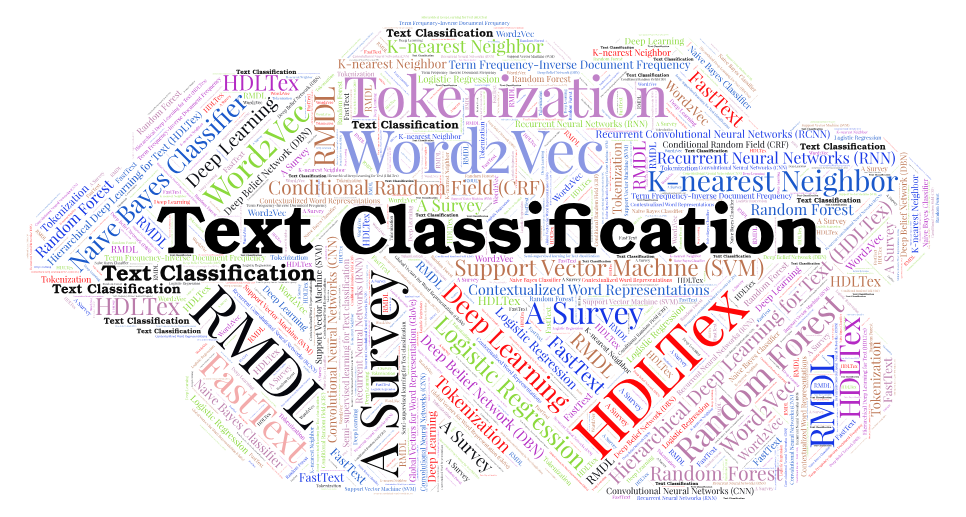

By : <a href="https://www.linkedin.com/in/bala-murugan-62073b212/">Balamurugan P</a>

> **TASK : To classify tweets as Offensive(1) / Non-offensive(0)**

> **EDA Notebook Link :** https://www.kaggle.com/balamurugan1603/twitter-sentiment-analysis-eda

# **Motivation :**
Hate speech is an unfortunately common occurrence on the Internet. Often social media sites like Facebook and Twitter face the problem of identifying and censoring problematic posts while weighing the right to freedom of speech. The importance of detecting and moderating hate speech is evident from the strong connection between hate speech and actual hate crimes. Early identification of users promoting hate speech could enable outreach programs that attempt to prevent an escalation from speech to action. Sites such as Twitter and Facebook have been seeking to actively combat hate speech. In spite of these reasons, NLP research on hate speech has been very limited, primarily due to the lack of a general definition of hate speech, an analysis of its demographic influences, and an investigation of the most effective features.


# **Data :**

**train.csv** - Labelled dataset of 31,962 tweets. Csv file with each line storing a tweet id, its label and the tweet.

**test.csv** - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

# **Metric :**

F1 Score is being used to compare the models due to class imbalance.

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

False Positives (FP) – When actual class is no and predicted class is yes.

False Negatives (FN) – When actual class is yes but predicted class in no.

Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2(Recall Precision) / (Recall + Precision)
F1 is usually more useful than accuracy, especially if for an uneven class distribution.

# **Dependencies :**

In [ ]:
%pip install contractions

import numpy as np
import pandas as pd
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, MaxPooling1D, Conv1D
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from IPython.display import display

# **Preprocessing :**

In [ ]:
data = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/train.csv")
display(data.head())
display(data.info())
print(data["tweet"][22])

In [ ]:
data.drop("id", axis=1, inplace=True)
display(data.head())
display(data.info())

In [ ]:
def expand_contractions(df_series):
    """ Expands contractions from text in pandas series.
        (Eg: can't --> cannot)
        
    Args:
        df_series (pd.Series): Pandas series containing text data.
    
    Returns:
        df_series (pd.Series): Pandas series containing text data after 
                               expanding contractions.
    """
    
    for i in range(len(df_series)):
        df_series[i] = contractions.fix(df_series[i])
    
    return df_series



def get_pos(token):
    """ Returns "part of speech" of the token which is understandable 
        by WordNetLemmatizer.
        
    Args:
        token (str): Single token whose POS to be identified.
    
    Returns:
        (str): POS tag of the token in a format understandable by WordNetLemmatizer.
    """
    
    pos_tag = nltk.pos_tag(token)[0][1][0].upper()
    pos_tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
    
    # Returns wordnet.NOUN as default if it can't find exact POS 
    return pos_tag_dict.get(pos_tag, wordnet.NOUN)



def lemmatize_series(df_series, remove_stopwords=False):
    """ Lemmatizes text data in pandas series and removes stopwords.
        
    Args:
        df_series (pd.Series): Pandas series containing text data.
        remove_stopwords (bool): Removes stopwords from the text if True. 
                                 Defaults to False.
                                 
    Returns:
        df_series (pd.Series): Pandas series containing lemmatized text data 
                               without stopwords if specified.
    """
    
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        lm = WordNetLemmatizer()
        for i in range(len(df_series)):
            df_series[i] = ' '.join([lm.lemmatize(word, get_pos(word)) 
                                     for word in df_series[i].split() 
                                      if not word.lower() in stop_words])
    else:
        lm = WordNetLemmatizer()
        for i in range(len(df_series)):
            df_series[i] = ' '.join([lm.lemmatize(word, get_pos(word)) 
                                     for word in df_series[i].split()])
    
    return df_series

In [ ]:
def preprocess_tweets(df_series, remove_stopwords=True):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        remove_stopwords (bool): Removes stopwords from tweets if True. Defaults to True. 
        
    Returns:
        df_series (pd.series): Pandas series object containing preprocessed tweets. 
    """
    
    # Expand contractions (Eg: can't --> cannot)
    df_series = expand_contractions(df_series)
    
    # Removes '@user' tags
    df_series = df_series.str.replace("@user", "", regex=False)
    
    # Removes '&amp' tags
    df_series = df_series.str.replace("&amp", " ")
    
    # Removes non alphanumeric characters
    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    
    # Lemmatize tweets
    df_series = lemmatize_series(df_series, remove_stopwords=remove_stopwords)
    
    return df_series

In [ ]:
data["tweet"] = preprocess_tweets(data["tweet"])
display(data.head())
print(data["tweet"][22])

In [ ]:
labels = {0: "Not Offensive", 1: "offensive"}
print(labels)

# **Splitting data :**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["label"],
                                                    stratify=data["label"],
                                                    train_size=0.8,
                                                    random_state=22)

In [ ]:
# displays shape of training and validation data
print(X_train.shape)
print(X_test.shape)

# **Function to plot confusion matrix :**

In [ ]:
def plot_confusion_matrix(conf_matrix):
    
    """ Plots confusion matrix.
    
    Args:
        conf_matrix (list): Array containing values as in the format returned
                            by 'sklearn.metrics.confusion_matrix'
                            
    Returns:
        Nothing
    
    """
    
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    

# **Text Classification models using dot product similarity :**

**Using word count vectors :**

Word count vector is the vector containing count of the words for words present in a document and 0 for words not present in the document but present in the whole corpus. 

In [ ]:
class CountVectorSentimentModel:
    
    """ 
    This class can be used to classify text data.
    
    Uses dot product to find similarity between given text and training
    data. Finds top similar training data's labels and returns most common
    labels from the top 7 labels as predicted label.
    
    NOTE: This statistical method uses CountVectorizer to vectorize 
    text, which returns word count vectors.
    
    ...
    
    Attributes
    ----------
    vect (CountVectorizer): CountVectorizer object fit on training data
                            to vectorize text.
        
    train_count_vectors (list): Array of word count vectors of training data.
    
    y_train (list): Array of labels of each observation in training data.
    
    
    Methods
    -------
    fit: Vectorizes text data and stores them for generating predictions.
        
    predict: Takes array of text data as argument to classify them.
    
    most_common: Finds and returns most frequent element from a list.
    
    get_dot_product: Converts text into word count vectors and multiply (dot product) 
                     it with vector stored by .fit() method.
    
    """
    
    
    def __init__(self):
        
        """ Class constructor.
        
        Args:
            Nothing
            
        Returns:
            Nothing
        
        """
        
        self.vect = CountVectorizer()    # Initializes vectorizer
        
    
    def fit(self, X_train, y_train): 
        
        """ Vectorizes text data and stores them for generating predictions.
        
        Args:
            X_train (list): Array containing text data to be vectorized and stored.
            y_train (list): Array of labels.
        
        Returns:
            Nothing
            
        """
        
        # Fit vectorizer on training data and vectorizes text
        self.train_count_vectors = self.vect.fit_transform(X_train).toarray()
        
        # Stores labels
        self.y_train = y_train.values
    
    
    def predict(self, X_test):
        
        """ Takes array of text data as argument to classify them.
        
        Args:
            X_test (list): Array of text data to classify.
            
        Returns:
            labels (list): Array of predicted labels.
        
        """
        
        labels = []
        for text in X_test:
            # Uses dot product to find similarity between given text and training
            # data. Finds top similar training data's labels and returns most common
            # labels from the top 7 labels as predicted label.
            
            dot_vector = self.get_dot_product(text)
            indices = np.argsort(dot_vector)[::-1][:7]  
            labels.append(self.most_common(self.y_train[indices]))
            
        return labels
    
    
    def most_common(self, lst):
        
        """ Finds and returns most frequent element from a list.
        
        Args:
            lst (list): Array from which most frequent element to be found.
            
        Returns:
            (int): Most frequent element in the array. 
        
        """
        
        data = Counter(lst)
        return data.most_common(1)[0][0]
        
    
    def get_dot_product(self, text):
        
        """ Converts text into word count vectors and multiply (dot product) it with
            vector stored by .fit() method.
            
        Args:
            text (str): String to be vectorized and multiplied (dot product) with 
                        vector stored by .fit() method.
                        
        Returns:
            dot_products (list): Array of values obtained by dot product.
            
        """
        
        count_vector = self.vect.transform([text]).toarray()[0]
        dot_products = count_vector.T@self.train_count_vectors.T
        return dot_products

In [ ]:
# Training
cvsm = CountVectorSentimentModel()
cvsm.fit(X_train, y_train)

*Time taken for single prediction :*

In [ ]:
%%timeit
cvsm.predict(["thought factory bbc neutrality on right wing fascism politics media blm brexit trump leaders"])

* *This method takes very longer time and infeasible to use for classification.*

**Let's optimize it**

In [ ]:
class CountVectorSentimentModelOptimized:
    
    """ 
    This class can be used to classify text data.
    
    Optimised version of CountVectorSentimentModel class.
    Uses same concept in a different, efficient way.
    
    Stores two vectors when calling .fit() method. One is non offensive 
    vector which is a single word count vector of all words in non offensive tweets.
    Another one is offensive vector which is a single word count vector of all words
    in offensive tweets. When calling .predict() method, Calculates dot product between
    given new vector and these two vectors. Category with highest dot product value is 
    returned as predicted label. This eliminates the loops, vectorizing operations
    and large matrices which were in old CountVectorSentimentModel which 
    accounts for improved performance.  
    
    NOTE: This statistical method uses CountVectorizer to vectorize 
    text, which returns word count vectors.
    
    ...
    
    Attributes
    ----------
    vect (CountVectorizer): CountVectorizer object fit on whole training data
                            to vectorize text.
        
    non_off_vector (list): Word count vector of non offensive data.
    
    off_vector (list): Word count vector of offensive data.
    
    
    Methods
    -------
    fit: Vectorizes text data and stores them for generating predictions.
        
    predict: Takes array of word count vectors as argument to classify them.
    
    vectorize: Vectorizes text into word count vectors with the same vectorizer 
               object fit on training data.
    
    """
    
    
    def __init__(self):
        
        """ Class constructor.
        
        Args:
            Nothing
            
        Returns:
            Nothing
            
        """
        
        self.vect = CountVectorizer()    # Initializes vectorizer
    
    
    def fit(self, train_df, X_col, y_col):
        
        """ Vectorizes all training data into single word count vector
            for each category and stores them to generate predictons.
            
        Args:
            train_df (pd.DataFrame): Pandas DataFrame object holding training data.
            X_col (str): Name of the column containing text data.
            y_col (str): Name of the column containing labels.
        
        Returns:
            Nothing
            
        """
        
        self.vect.fit(train_df[X_col])    # Fitting vectorizer to training data
        
        # Subsetting data by each category
        non_off_tweets = train_df[train_df[y_col]==0][X_col].values
        off_tweets = train_df[train_df[y_col]==1][X_col].values
        
        # Concatinating all non offensive tweets into single string 
        whole_non_off_tweets = ""
        for tweet in non_off_tweets:
            whole_non_off_tweets += tweet
            
        # Concatinating all offensive tweets into single string
        whole_off_tweets = ""
        for tweet in off_tweets:
            whole_off_tweets += tweet
        
        # Vectorizing and storing each vector 
        self.non_off_vector = self.vect.transform([whole_non_off_tweets]).toarray()[0]
        self.off_vector = self.vect.transform([whole_off_tweets]).toarray()[0]
        
    
    def predict(self, X_test_vectors):
        
        """ Takes word count vectors as argument and returns predicted labels. 
        
        Args:
            X_test_vectors (list): Word count vectors.
            
        Returns:
            y_pred (list): Array of predicted labels.  
        
        """
        
        # Calculates dot product between X_test_vectors and non_off_vector
        # stored by .fit() method and X_test_vectors and off_vector stored by
        # .fit() method. category which has the highest dot product value
        # is the predicted label.
          
        non_off_weights = self.non_off_vector.T@X_test_vectors.T
        off_weights = self.off_vector.T@X_test_vectors.T
        
        y_pred = []
        for i in range(len(non_off_weights)):
            y_pred.append(np.argmax([non_off_weights[i], off_weights[i]]))
        
        return y_pred

    
    def vectorize(self, X_test):
        
        """ Used to vectorize text into word count vectors with the same
            vectorizer object fit on training data.
            
        Args:
            X_test (list): Array containing text data.
            
        Returns:
            (list): Array of word count vectors.
        
        """
        return self.vect.transform(X_test).toarray()
    

In [ ]:
# Converting data into compatible format
train_df = pd.DataFrame({"tweets": X_train, "labels": y_train})
train_df.reset_index(drop=True, inplace=True)
display(train_df.head())

In [ ]:
# Training
cvsm_opt = CountVectorSentimentModelOptimized()
cvsm_opt.fit(train_df, X_col="tweets", y_col="labels")

In [ ]:
# Vectorizing sample text
trial_vect = cvsm_opt.vectorize(["thought factory bbc neutrality on right wing fascism politics media blm brexit trump leaders"])

*Time taken for single prediction :*

In [ ]:
%%timeit
cvsm_opt.predict(trial_vect)

* *Hmm...Thats pretty quicker.*

In [ ]:
# Gets predictions
X_test_vect = cvsm_opt.vectorize(X_test)
y_pred_cvsm = cvsm_opt.predict(X_test_vect)

In [ ]:
# Plots confusion matrix and displays classification report
conf_matrix_cvsm = confusion_matrix(y_test, y_pred_cvsm)
plot_confusion_matrix(conf_matrix_cvsm)
print(classification_report(y_test, y_pred_cvsm, target_names=["Not offensive", "offensive"]))

In [ ]:
# Dictionary to store F1 Scores of different models
f1_dict = {}

In [ ]:
# Updates model score to f1_dict
f1_dict["cvsm"] = f1_score(y_test, y_pred_cvsm)

**Using Term frequency - Inverse document frequency vectors :**


In Tf-Idf vectors, The weights for frequent words are close to 0. So, We will have higher value for unique words present in the corpus.

In [ ]:
class TfidfSentimentModel(CountVectorSentimentModelOptimized):
    
    """ 
    This class can be used to classify text data.
    
    Inherits all attributes and methods from CountVectorSentimentModelOptimized
    class except that the vectorizer used is different.
    
    Tf-Idf vectors are more useful than word count vectors in this context since
    the weights for common words are close to 0 in Tf-Idf vectors. So, We will have
    higher value for unique words present in different classes.
    
    NOTE: This statistical method uses TfidfVectorizer to vectorize 
    text, which returns Tf-Idf vectors.
    
    ...
    
    Attributes
    ----------
    vect (CountVectorizer): CountVectorizer object fit on whole training data
                            to vectorize text.
        
    non_off_vector (list): Word count vector of non offensive data.
    
    off_vector (list): Word count vector of offensive data.
    
    
    Methods
    -------
    fit: Vectorizes text data and stores them for generating predictions.
        
    predict: Takes array of word count vectors as argument to classify them.
    
    vectorize: Vectorizes text into word count vectors with the same vectorizer 
               object fit on training data.
    
    """
    
    def __init__(self):
        self.vect = TfidfVectorizer()    # Initializes vectorizer
        
        

In [ ]:
# Training
tvsm = TfidfSentimentModel()
tvsm.fit(train_df, X_col="tweets", y_col="labels")

In [ ]:
# Vectorizing sample text
trial_vect = tvsm.vectorize(["thought factory bbc neutrality on right wing fascism politics media blm brexit trump leaders"])

*Time taken for single prediction :*

In [ ]:
%%timeit
tvsm.predict(trial_vect)

In [ ]:
# Gets predictions
X_test_vect = tvsm.vectorize(X_test)
y_pred_tfidf = tvsm.predict(X_test_vect)

In [ ]:
# Plots confusion matrix and displays classification report
conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plot_confusion_matrix(conf_matrix_tfidf)
print(classification_report(y_test, y_pred_tfidf, target_names=["Not offensive", "offensive"]))

# Updates model score to f1_dict
f1_dict["tvsm"] = f1_score(y_test, y_pred_tfidf)

# **Text classification using word embeddings and deep learning :**

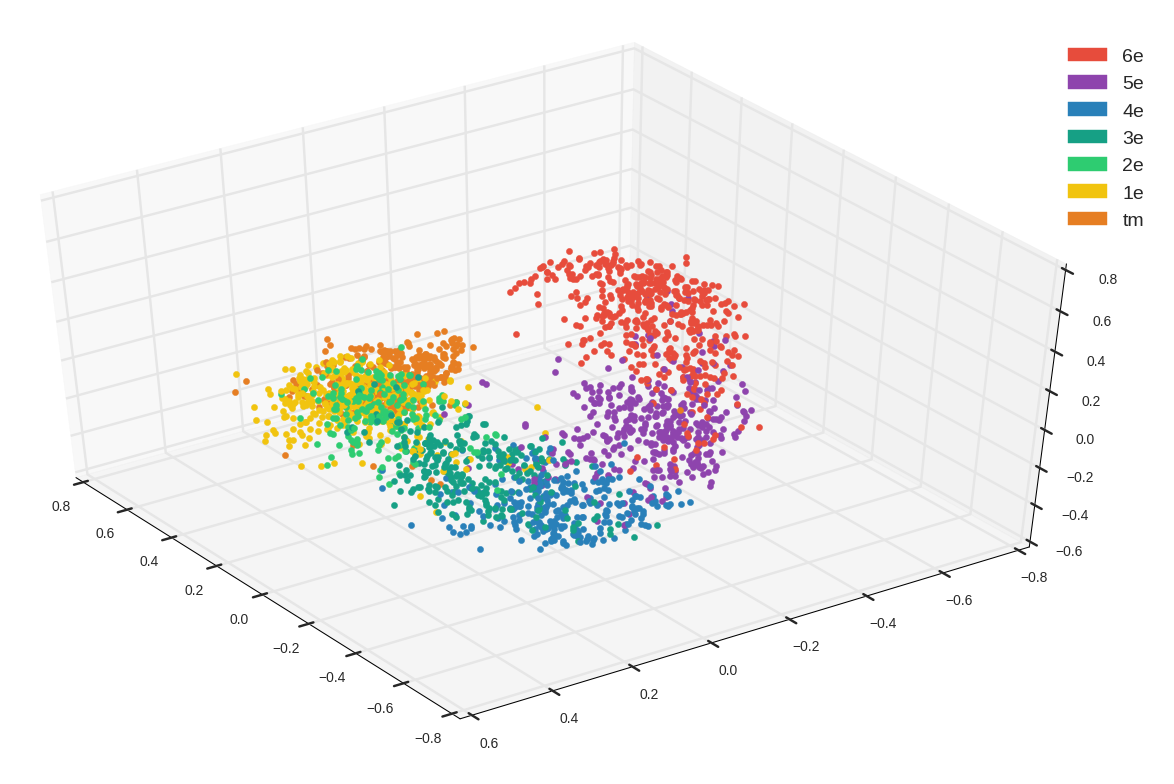

*In the above plot each point represents a word and each cluster represents a category. This Image is attached just for better understanding of word embeddings.*

Word embeddings are layers used in neural networks which projects words into higher dimensional vectors. Unlike other text vectorization techniques, word embedding layers trains as like other neural network layers. The words with similar meaning are clustered together at the end of training. Embedding layers understands the meaning of the words from the labels.

In [ ]:
def plot_history(history):
    
    """ Plots training history of models.
    
    Args:
        history (History): Tensorflow History object containing training 
                           history of the model.
                           
    Returns:
        Nothing
        
    """
    
    history_dict = history.history
    train_loss = history_dict['loss']    # Training loss over epochs
    val_loss = history_dict['val_loss']    # Validation loss over epochs
    epochs = range(1, len(history_dict['loss'])+1)
    plt.plot(epochs, train_loss,'b', label='Training error')
    plt.plot(epochs, val_loss,'b', color="orange", label='Validation error')
    plt.title('Training and Validation error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()
    
    

In [ ]:
# Defining parameters
vocab_size = 30000
embedding_dim = 18
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_token = "<OOV>"

In [ ]:
# Fitting tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Converting texts to sequences and padding them to make
# them compatible with embedding layers

training_seq = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_seq,
                                truncating = trunc_type,
                                padding = padding_type,
                                maxlen = max_len)

testing_seq = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_seq,
                               truncating = trunc_type,
                               padding = padding_type,
                               maxlen = max_len)

**Model with Embedding layer and normal dense layers :**

In [ ]:
# Defining model architecture and compiling

embedding_model1 = Sequential([
            Embedding(vocab_size, embedding_dim, input_length=max_len),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(8, activation="relu"),
            Dense(4, activation="relu"),
            Dense(1, activation="sigmoid")
        ])

embedding_model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Displays model summary
display(embedding_model1.summary())

In [ ]:
# Training
history1 = embedding_model1.fit(training_padded, 
                              y_train.values, 
                              validation_data=(testing_padded, y_test.values),
                              epochs=5,
                              batch_size=32)

In [ ]:
# Plots loss over epochs
plot_history(history1)

In [ ]:
# Gets predictions
y_pred_embedding_model1 = embedding_model1.predict(testing_padded).flatten()
y_pred_embedding_model1 = [1 if x>=0.5 else 0 for x in y_pred_embedding_model1]

In [ ]:
# Plots confusion matrix and displays classification report
conf_matrix_embedding_model1 = confusion_matrix(y_test, y_pred_embedding_model1)
plot_confusion_matrix(conf_matrix_embedding_model1)
print(classification_report(y_test, y_pred_embedding_model1, 
                            target_names=["Not offensive", "offensive"]))

# Updates model score to f1_dict
f1_dict["embedding_model"] = f1_score(y_test, y_pred_embedding_model1)

**Model with Embedding, 1-dimensional Convolutions (Conv1D) and Dense layers :**

In [ ]:
# Defining model architecture and compiling

embedding_model2 = Sequential([
            Embedding(vocab_size, embedding_dim, input_length=max_len),
            Conv1D(16, 4, activation="relu"),
            MaxPooling1D(2),
            Conv1D(32, 4, activation="relu"),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(8, activation="relu"),
            Dense(4, activation="relu"),
            Dense(1, activation="sigmoid")
        ])

embedding_model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Displays model summary
embedding_model2.summary()

In [ ]:
# Training
history2 = embedding_model2.fit(training_padded, 
                              y_train.values, 
                              validation_data=(testing_padded, y_test.values),
                              epochs=5,
                              batch_size=32)

In [ ]:
# Plots loss over epochs
plot_history(history2)

In [ ]:
# Gets predictions
y_pred_embedding_model2 = embedding_model2.predict(testing_padded).flatten()

In [ ]:
y_pred_embedding_model2 = [1 if x>=0.5 else 0 for x in y_pred_embedding_model2]

In [ ]:
# Plots confusion matrix and displays classification report
conf_matrix_embedding_model2 = confusion_matrix(y_test, y_pred_embedding_model2)
plot_confusion_matrix(conf_matrix_embedding_model2)
print(classification_report(y_test, y_pred_embedding_model2, target_names=["Not offensive", "offensive"]))

# Updates model score to f1_dict
f1_dict["embedding_model_conv1D"] = f1_score(y_test, y_pred_embedding_model2)

In [ ]:
# Displays F1 Score of all models
print(f1_dict)

In [ ]:
# Displays comparison of models based on F1 Score
x = list(f1_dict.keys())
y = list(f1_dict.values())
ax = sns.barplot(y, x)
ax.set_xlabel("F1 Score")
plt.show()

*Embedding along with conv1D layers performs slightly better than other methods. The performance of less complex model which uses Tf-Idf and dot product that I have created is also not bad.*

# **Save the models :**

In [ ]:
# Saving trained version of optimized count vector sentiment model
cvsm_file = open("cvsm.obj", 'wb')
pickle.dump(cvsm_opt, cvsm_file)

# Saving trained version of optimized Tf-Idf vector sentiment model
tvsm_file = open("tvsm.obj", 'wb')
pickle.dump(tvsm, tvsm_file)

# Saving word embedding model
save_model(embedding_model1, "embedding")

# Saving word embedding model
save_model(embedding_model2, "embedding_conv1d")